In [18]:
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, Dataset

from pydub import AudioSegment
import soundfile as sf

import matplotlib.pyplot as plt
import librosa.display

In [19]:
class MelDataset(Dataset):
    def __init__(self, wav_dir, sr=44100, n_mels=128, duration=10, preload=True):
        self.files = [os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith('.wav')]
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.n_frames = int(np.ceil(sr * duration / 512))  # assuming hop_length=512
        self.preload = preload

        if self.preload:
            print(f"🔁 Preloading {len(self.files)} audio files into memory...")
            self.cache = [self.process_file(f) for f in self.files]
        else:
            self.cache = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.preload:
            return self.cache[idx]
        else:
            return self.process_file(self.files[idx])

    def process_file(self, path):
        y, _ = librosa.load(path, sr=self.sr)
        y = y[:self.sr * self.duration]
        if len(y) < self.sr * self.duration:
            y = np.pad(y, (0, self.sr * self.duration - len(y)), mode='constant')

        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, hop_length=512)
        mel_db = librosa.power_to_db(mel, ref=np.max).T  # [T, n_mels]

        if mel_db.shape[0] < self.n_frames:
            pad_len = self.n_frames - mel_db.shape[0]
            mel_db = np.pad(mel_db, ((0, pad_len), (0, 0)), mode='constant')
        else:
            mel_db = mel_db[:self.n_frames]

        mel_db = (mel_db + 80.0) / 80.0
        mel_db = mel_db * 2.0 - 1.0
        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0)  # [1, T, n_mels]
        return mel_tensor


In [20]:
class VAE(nn.Module):
    def __init__(self, input_dim=(157, 64), latent_dim=32128):
        super().__init__()
        c, t = input_dim  # (mel bins, time)

        # === Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # NEW LAYER
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(self.encoder_conv, self.flatten)

        # === Infer decoder shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, c, t)
            features = self.encoder_conv(dummy_input)
            self.decoder_shape = features.shape[1:]  # (C, H, W)
            self.enc_out_dim = features.view(1, -1).size(1)
            print(f"decoder_shape: {self.decoder_shape} → flattened: {self.enc_out_dim}")

        # === Latent space
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.enc_out_dim)

        # === Decoder (reduced channels + dropout)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=(2, 2), padding=1, output_padding=1),  # (108 → ~216, 16 → ~32)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=(2, 2), padding=1, output_padding=1),  # (~216 → ~432, ~32 → ~64)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=(2, 2), padding=1, output_padding=1),  # (~432 → ~864, ~64 → ~128)
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 1, kernel_size=3, padding=1),  # final output shape: [B, 1, 861, 128]
            nn.Tanh()
        )



        # === Init: Decoder
        for m in self.decoder.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        # === Init: Encoder
        for m in self.encoder_conv.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), *self.decoder_shape)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [21]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    # Align output/input spatial dims
    _, _, H, W = x.shape
    x_recon = x_recon[:, :, :H, :W]

    # === Reconstruction loss (mean MSE per pixel)
    recon_loss = F.mse_loss(x_recon, x, reduction='none')  # [B, 1, H, W]
    recon_loss = recon_loss.view(x.size(0), -1).mean(dim=1).mean()  # batch mean of per-sample means

    # === KL divergence (standard VAE form)
    logvar = torch.clamp(logvar, min=-10, max=10)  # Avoid nan in exp
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)  # batch mean

    # === Total loss
    return recon_loss + beta * kl_loss, recon_loss, kl_loss


In [22]:
dataset = MelDataset("data/", sr=44100, n_mels=128, duration=10)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

🔁 Preloading 850 audio files into memory...


Input mel shape: 862 x 128
🚀 Using device: cuda
decoder_shape: torch.Size([64, 108, 16]) → flattened: 110592
Epoch 01: Loss=0.7430  Recon=0.6893  KL=2.9868  Beta=0.02
Epoch 02: Loss=0.6840  Recon=0.6694  KL=0.7705  Beta=0.02
Epoch 03: Loss=0.6609  Recon=0.6505  KL=0.5262  Beta=0.02
Epoch 04: Loss=0.6408  Recon=0.6320  KL=0.4231  Beta=0.02
Epoch 05: Loss=0.6215  Recon=0.6138  KL=0.3493  Beta=0.02
Epoch 06: Loss=0.6038  Recon=0.5972  KL=0.2883  Beta=0.02
Epoch 07: Loss=0.5862  Recon=0.5804  KL=0.2410  Beta=0.02
Epoch 08: Loss=0.5687  Recon=0.5636  KL=0.1993  Beta=0.03
Epoch 09: Loss=0.5536  Recon=0.5491  KL=0.1660  Beta=0.03
Epoch 10: Loss=0.5377  Recon=0.5339  KL=0.1357  Beta=0.03


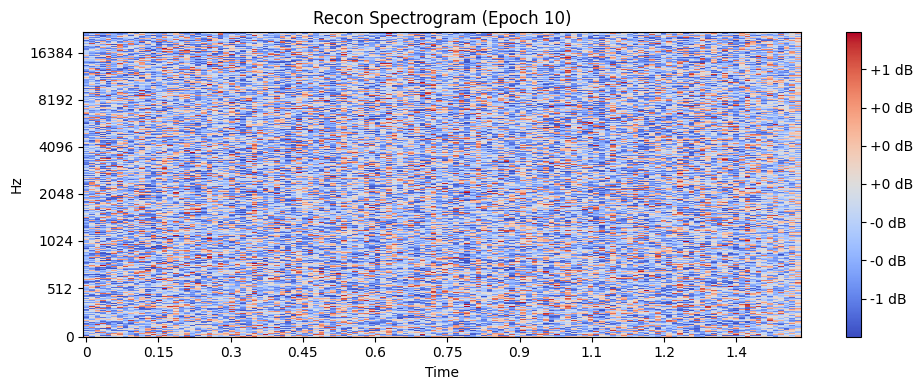

Epoch 11: Loss=0.5234  Recon=0.5201  KL=0.1102  Beta=0.03
Epoch 12: Loss=0.5092  Recon=0.5063  KL=0.0925  Beta=0.03
Epoch 13: Loss=0.4967  Recon=0.4943  KL=0.0760  Beta=0.03
Epoch 14: Loss=0.4845  Recon=0.4824  KL=0.0619  Beta=0.03
Epoch 15: Loss=0.4731  Recon=0.4713  KL=0.0524  Beta=0.04
Epoch 16: Loss=0.4627  Recon=0.4611  KL=0.0439  Beta=0.04
Epoch 17: Loss=0.4525  Recon=0.4511  KL=0.0360  Beta=0.04


KeyboardInterrupt: 

In [23]:
# === Get Actual Input Size from Dataset ===
sample_batch = next(iter(train_loader))  # e.g., [B, 1, 64, T]
mel_dim, time_dim = sample_batch.shape[-2], sample_batch.shape[-1]
print(f"Input mel shape: {mel_dim} x {time_dim}")

# === Create VAE Model with Correct Input Shape ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

model = VAE(input_dim=(mel_dim, time_dim), latent_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# === Training Loop ===
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    # Slower sigmoid annealing centered around epoch 20
    # In your training loop
    beta = float(1 / (1 + np.exp(-0.05 * (epoch - 80))))



    for x_batch in train_loader:
        x_batch = x_batch.to(device)
        x_recon, mu, logvar = model(x_batch)
        loss, recon, kl = vae_loss(x_recon, x_batch, mu, logvar, beta=beta)

        # === Monitor z collapse
        with torch.no_grad():
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            z_std = z.std().item()
            z_mean = z.mean().item()

            if z_std < 0.01:
                print("🚨 Latent space collapsed — z.std too small")
                break

        if torch.isnan(loss) or torch.isinf(loss) or loss.item() == 0:
            print("⚠️ Skipping NaN or zero loss batch")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)

    print(f"Epoch {epoch+1:02d}: Loss={avg_loss:.4f}  Recon={avg_recon:.4f}  KL={avg_kl:.4f}  Beta={beta:.2f}")
    torch.cuda.empty_cache()


    # === Visualize reconstruction every 5 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            x_val = next(iter(train_loader)).to(device)
            x_recon, _, _ = model(x_val)
            mel = x_recon[0].squeeze().cpu().numpy()

            import matplotlib.pyplot as plt
            import librosa.display
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel, sr=44000, hop_length=512, x_axis='time', y_axis='mel')
            plt.title(f"Recon Spectrogram (Epoch {epoch+1})")
            plt.colorbar(format="%+2.0f dB")
            plt.tight_layout()
            plt.show()


In [ ]:
def plot_mel_output(mel_out, sr=44000, hop_length=512, title="Mel Output"):
    if torch.is_tensor(mel_out):
        mel_out = mel_out.detach().cpu().numpy()
    if mel_out.ndim == 3:
        mel_out = mel_out.squeeze()

    mel_out = np.clip(mel_out, -1.0, 1.0)
    mel_db = np.clip(mel_out * 40.0, -80.0, 0.0)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.title(f"{title} | Range: {mel_db.min():.1f} to {mel_db.max():.1f} dB")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()


🎵 Generating 32 clips using real latent vectors


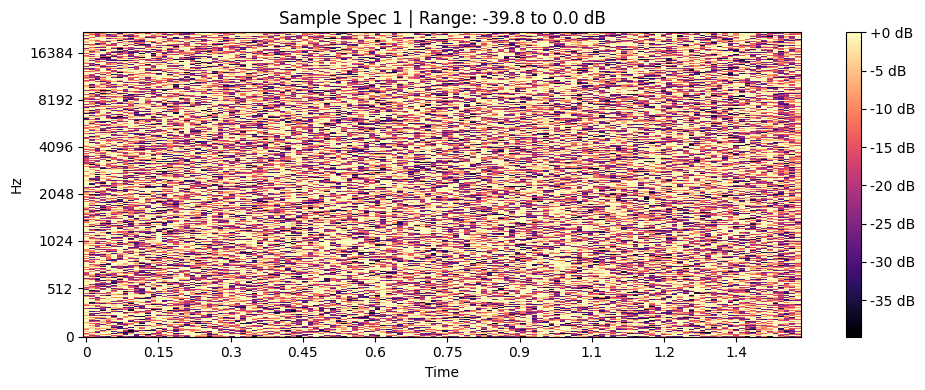

/home/roguchi/cse253-assignment2/.venv/lib/python3.12/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


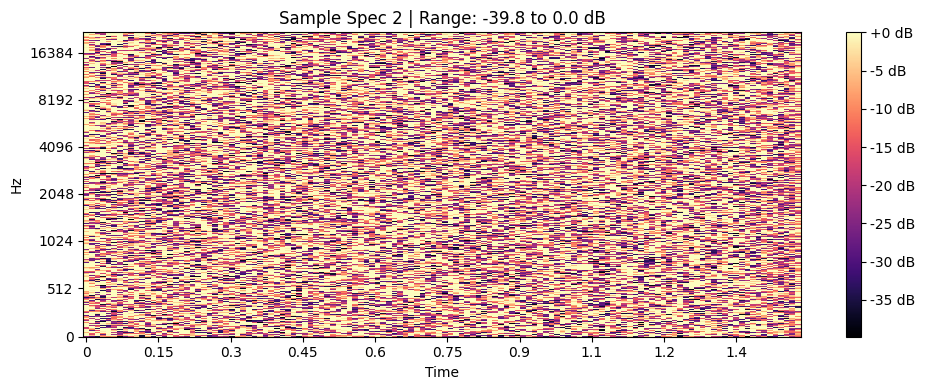

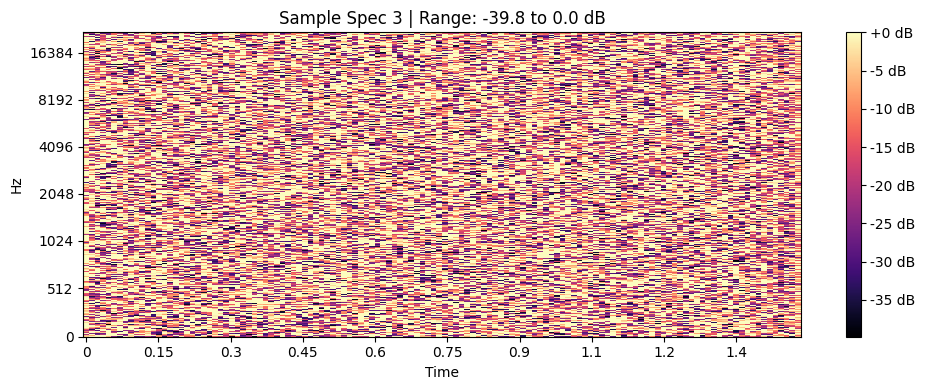

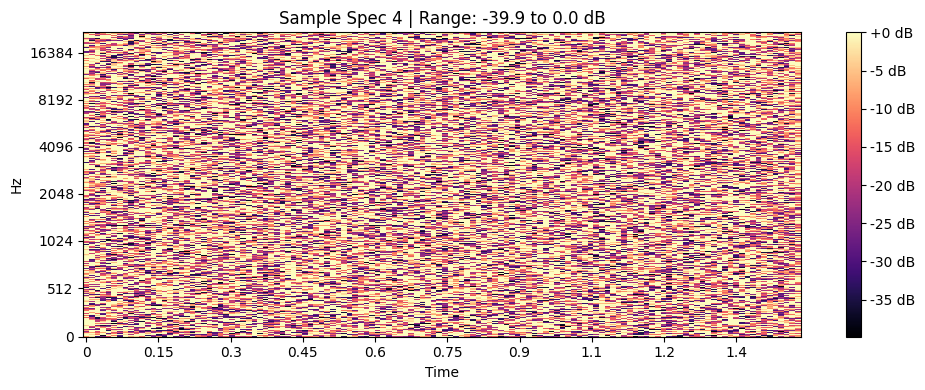

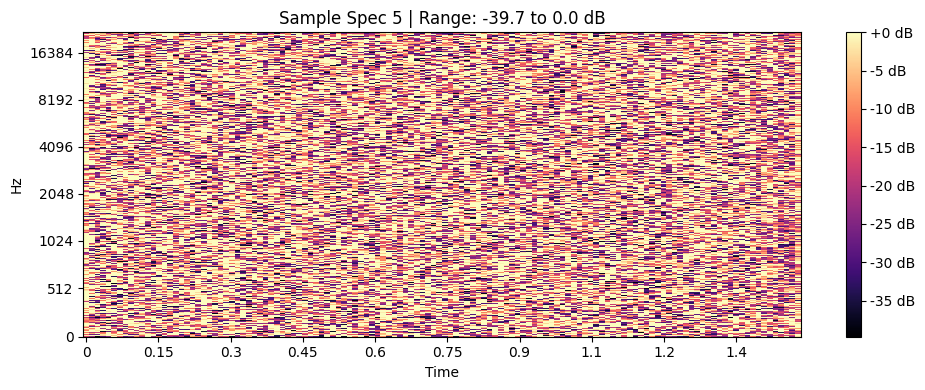

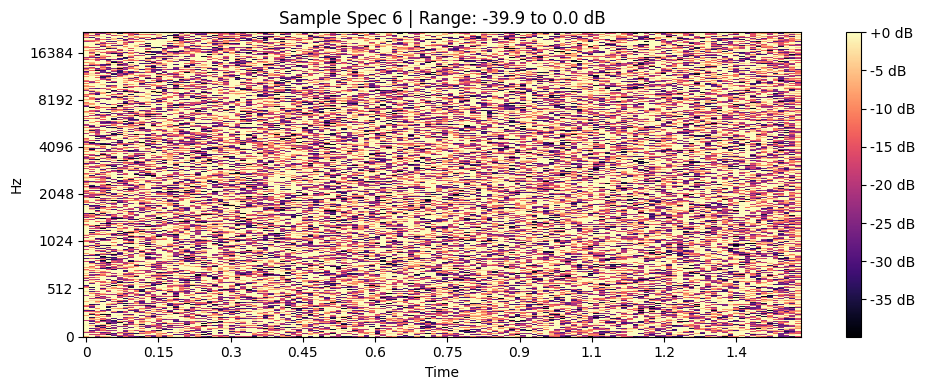

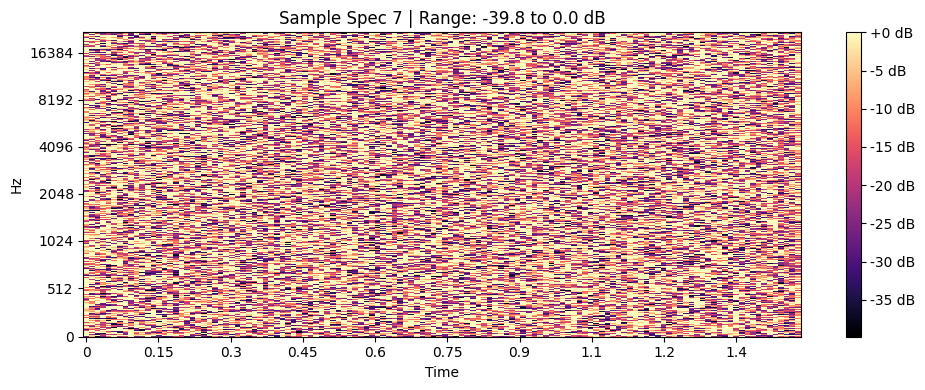

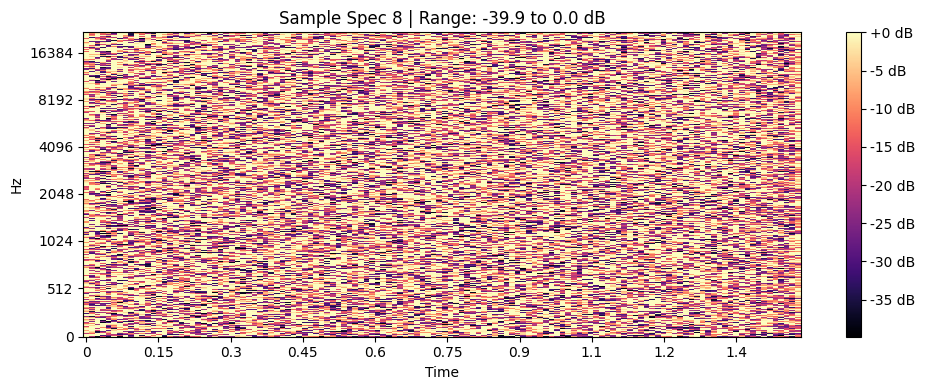

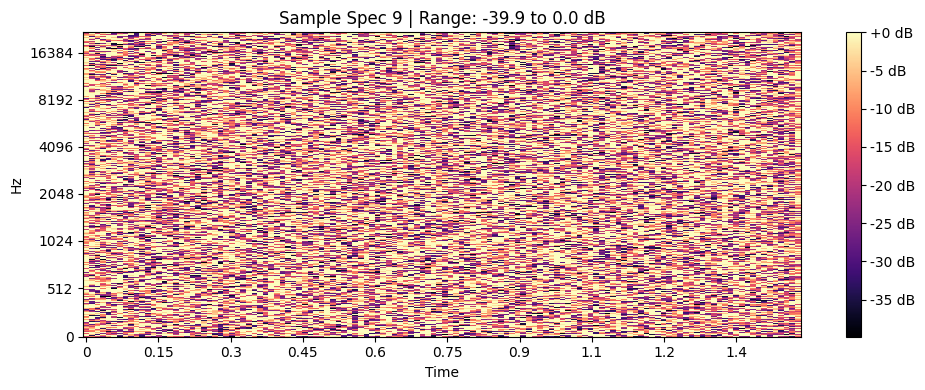

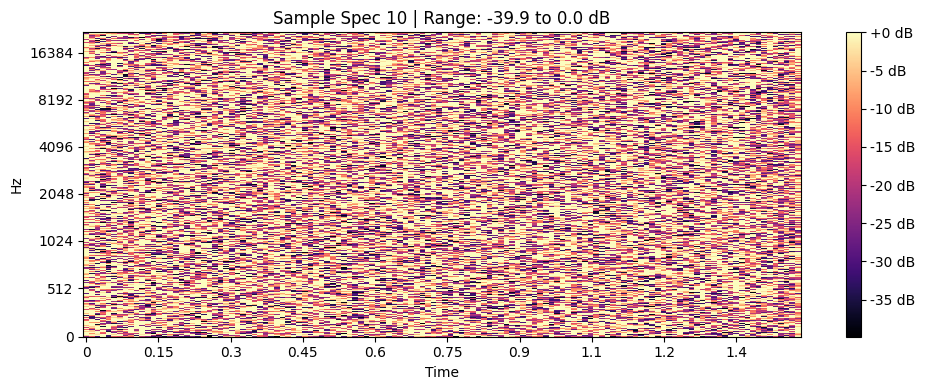

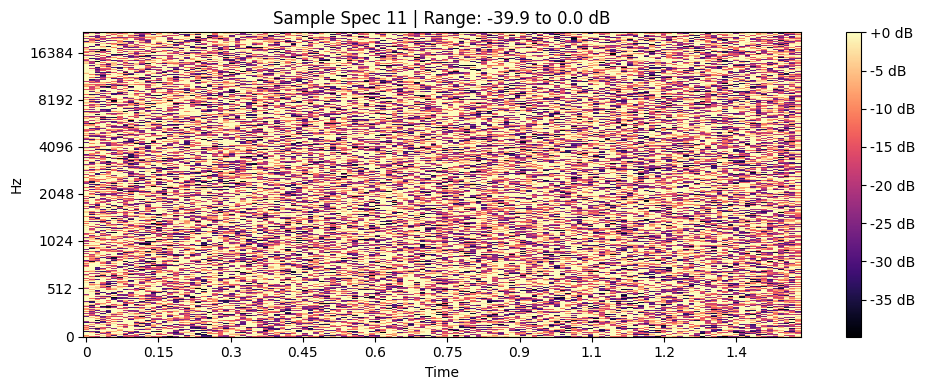

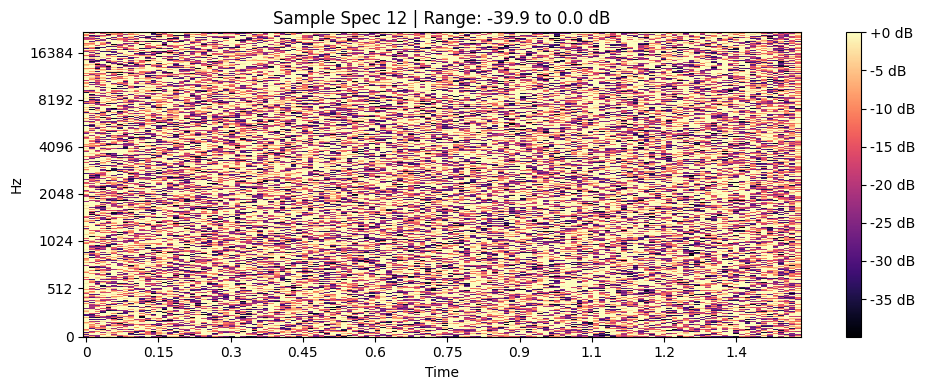

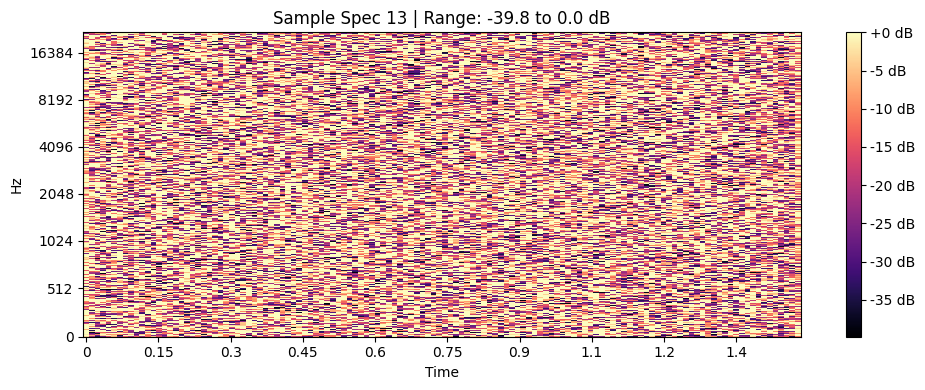

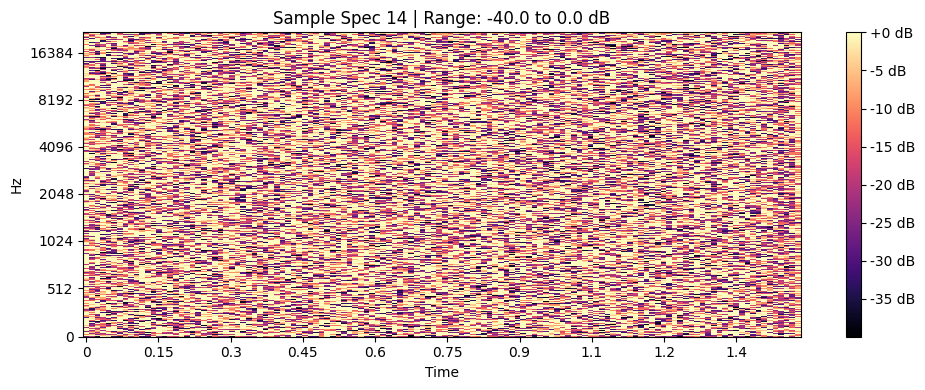

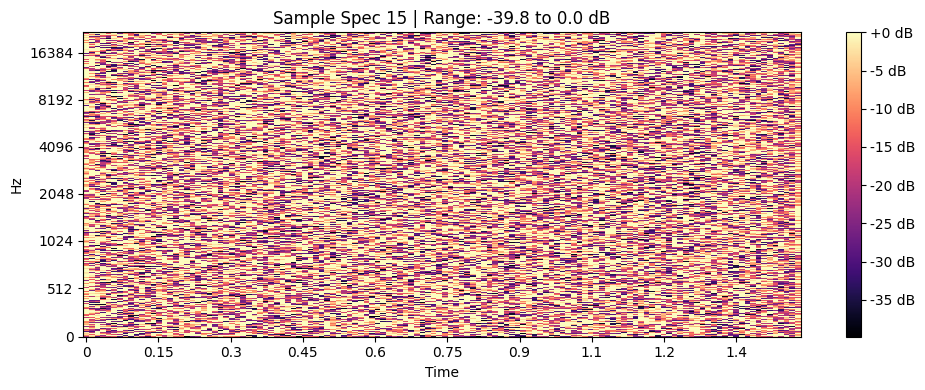

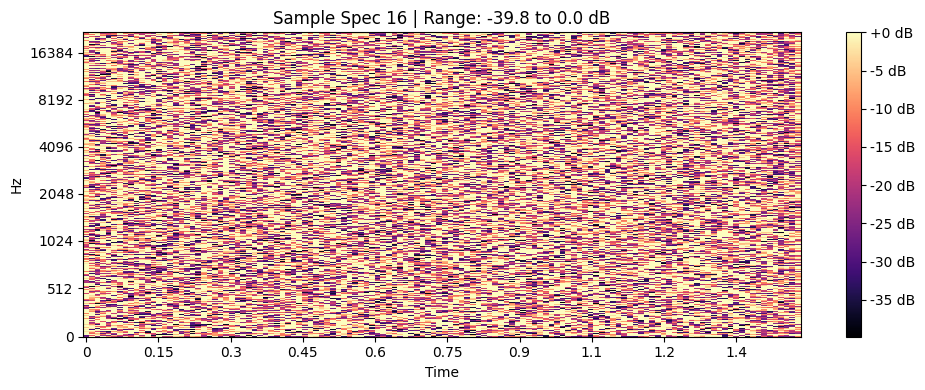

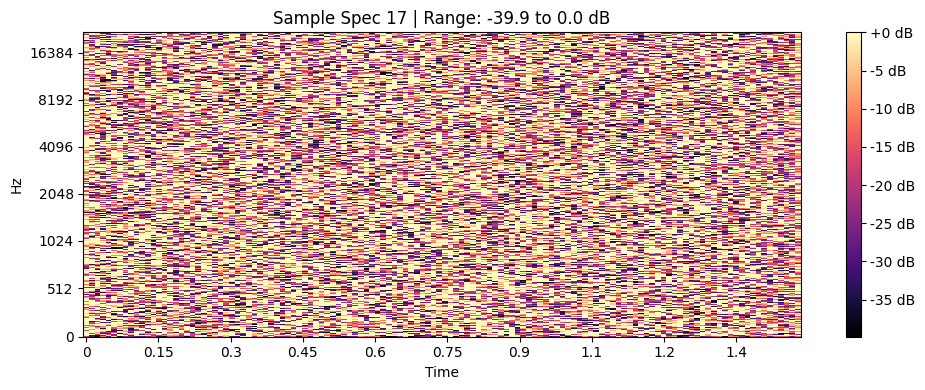

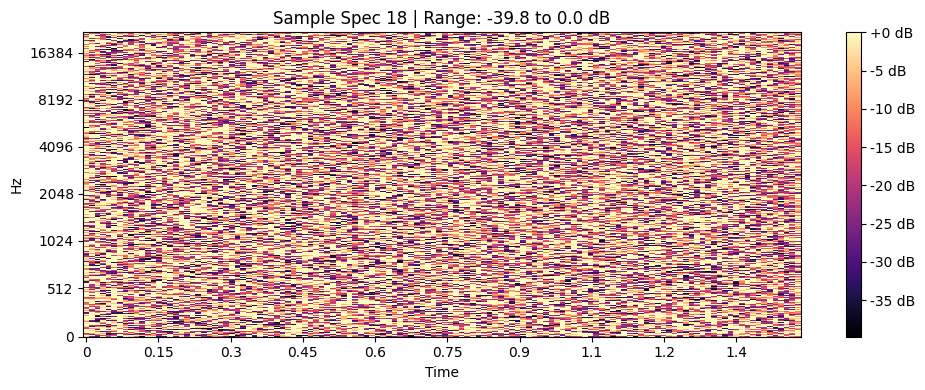

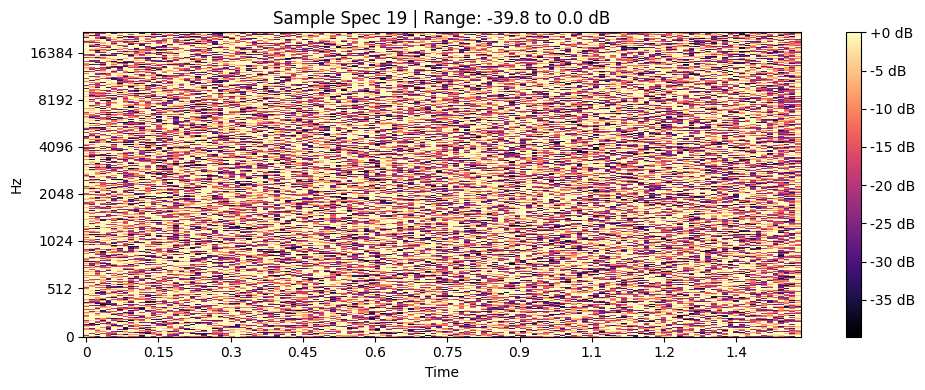

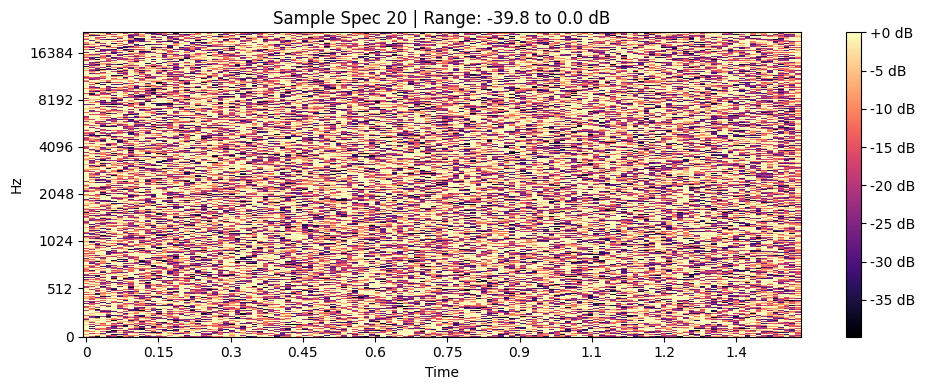

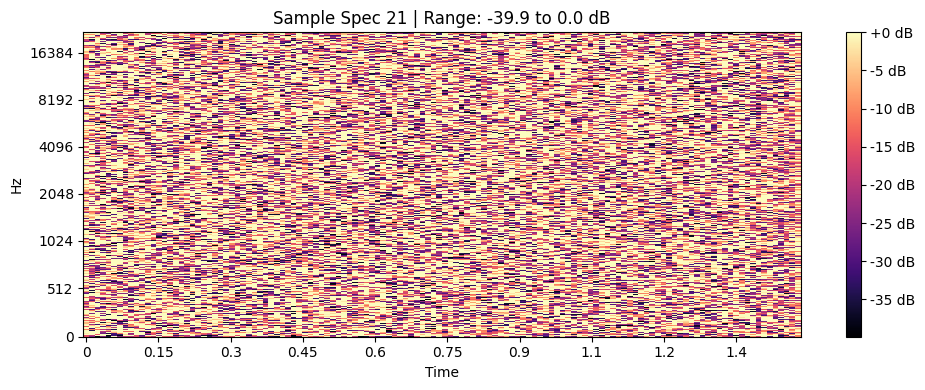

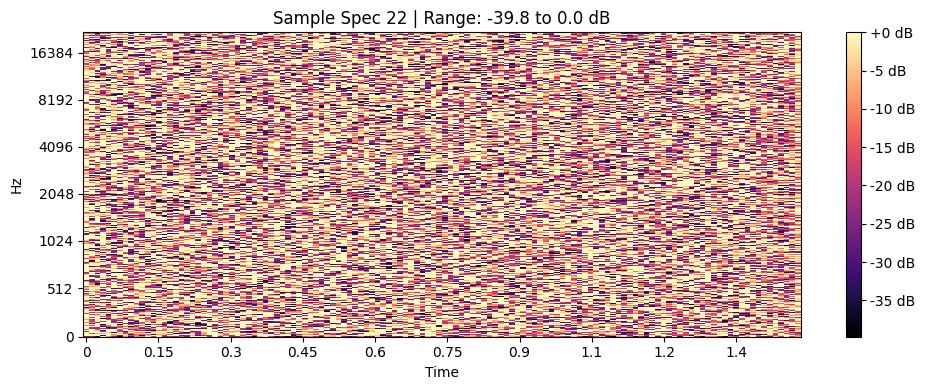

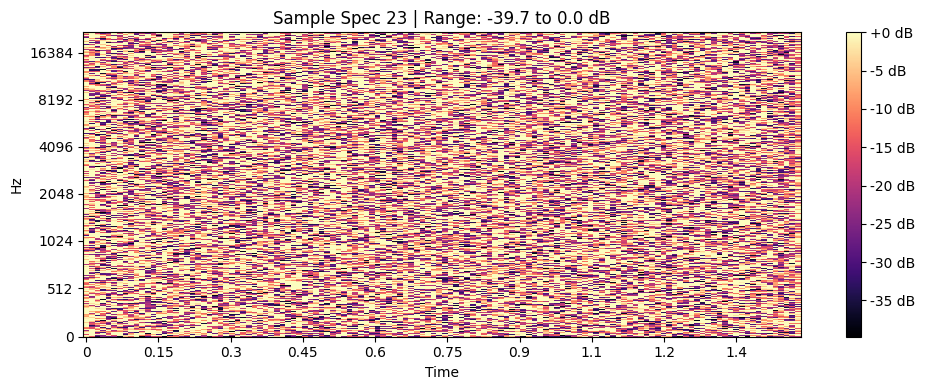

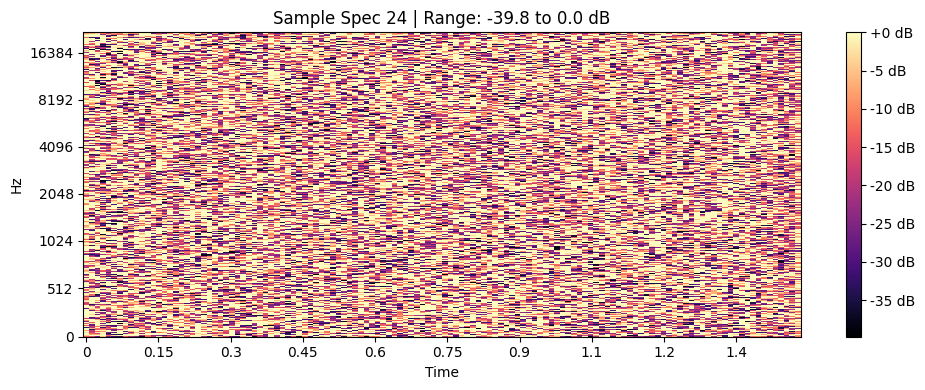

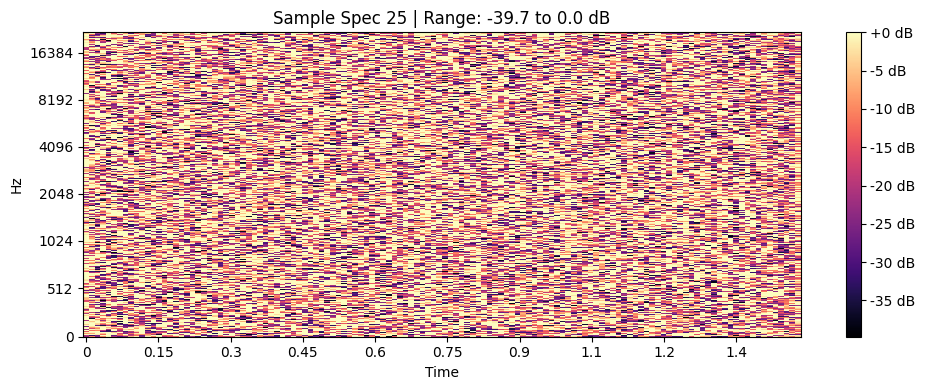

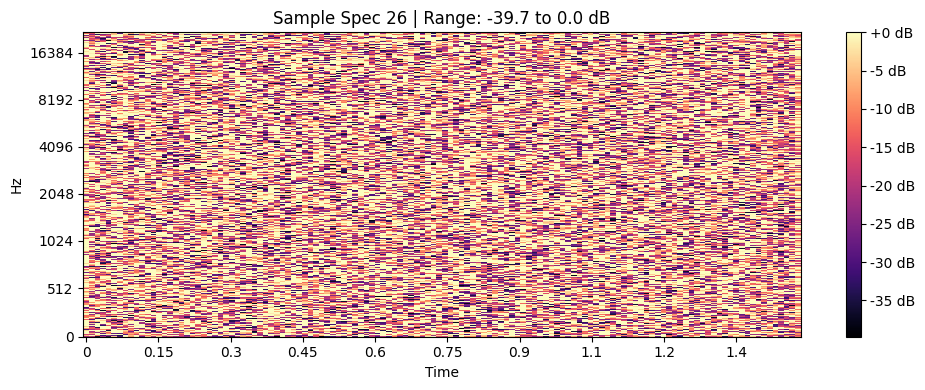

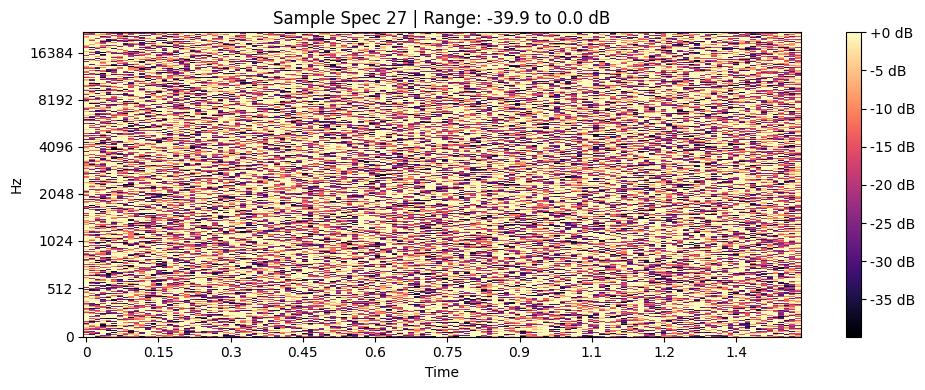

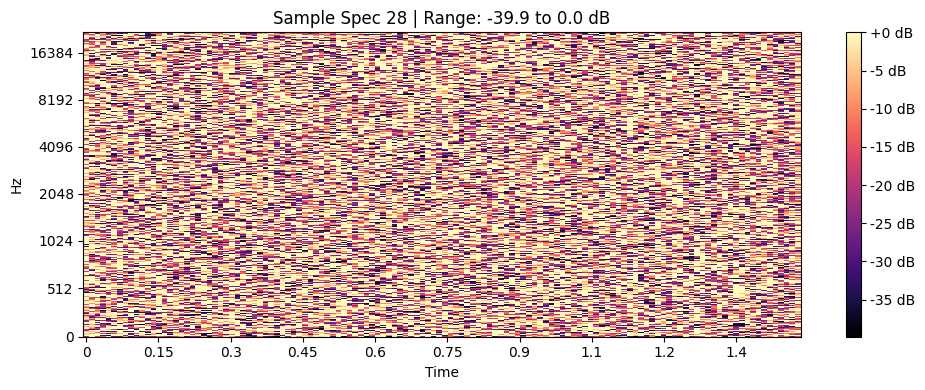

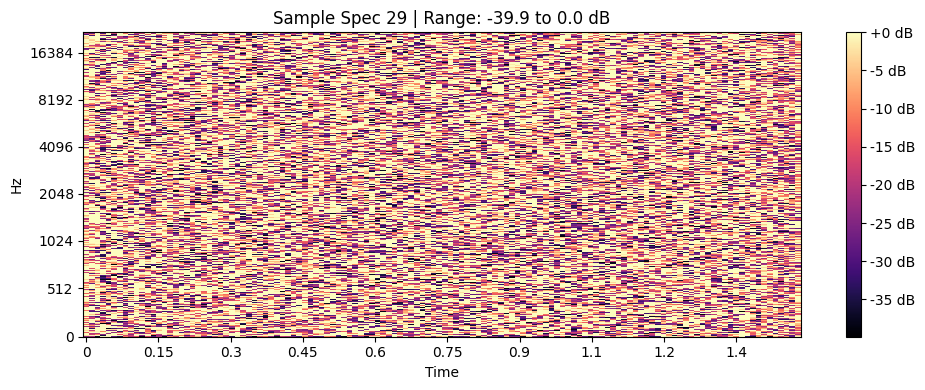

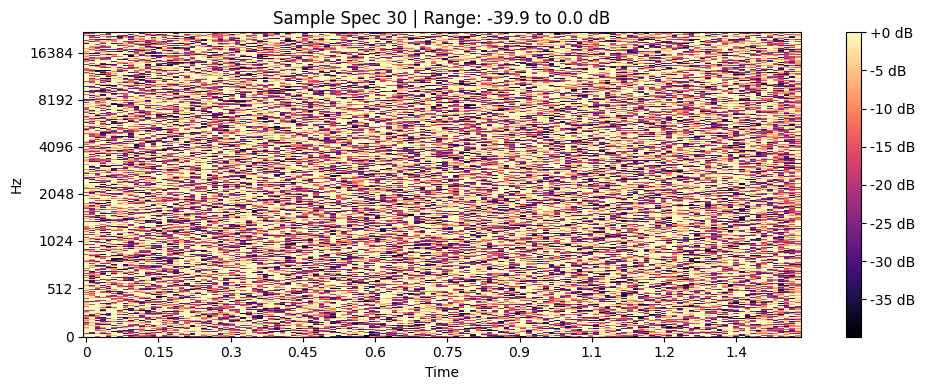

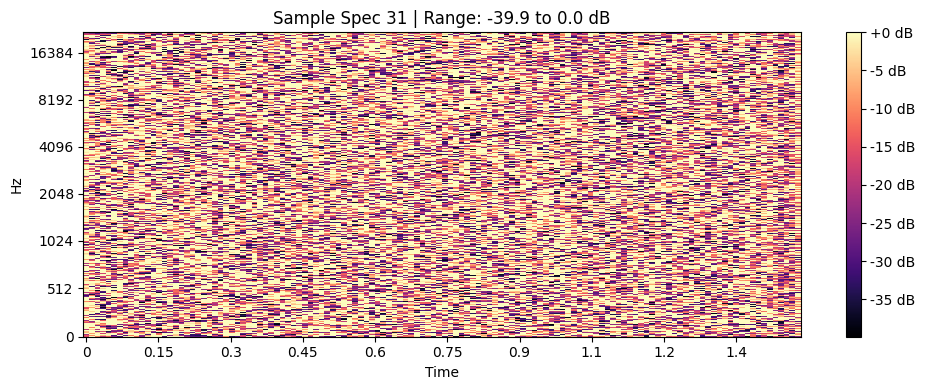

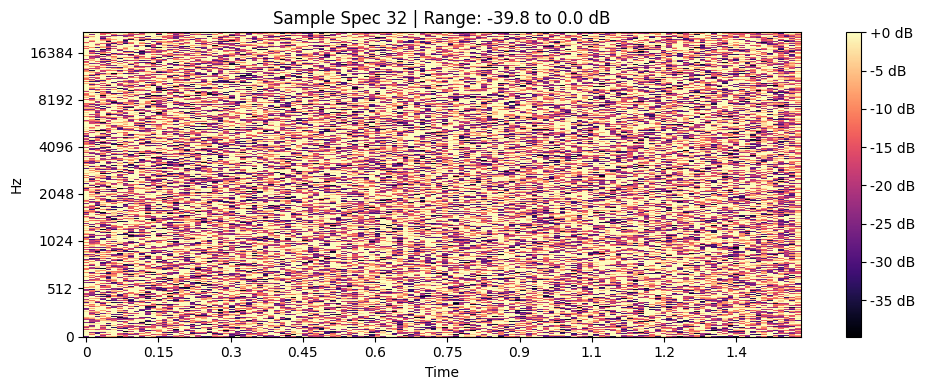

✅ Exported continuous_unconditioned.mp3 — total duration: 47.3 seconds


In [ ]:
def generate_audio_sample(model, train_loader, sr=44000, target_duration=120, device=None):

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    audio_clips = []
    hop_length = 512
    os.makedirs("temp_clips", exist_ok=True)

    with torch.no_grad():
        sample_batch = next(iter(train_loader)).to(device)
        mu, logvar = model.encode(sample_batch)
        z_all = model.reparameterize(mu, logvar)

    n_samples = z_all.size(0)
    print(f"🎵 Generating {n_samples} clips using real latent vectors")

    for i in range(n_samples):
        z = z_all[i].unsqueeze(0)
        with torch.no_grad():
            mel_out = model.decode(z).cpu().squeeze().numpy()

        # === Plot (optional)
        plot_mel_output(mel_out, sr=sr, title=f"Sample Spec {i+1}")

        # === Proper scaling: [-1, 1] → [-40, 0] dB
        mel_out = np.clip(mel_out, -1.0, 1.0)  # Avoid runaway energy
        mel_db = np.clip(mel_out * 40.0, -80.0, 0.0)
        # === Convert to power spec
        mel_power = librosa.db_to_power(mel_db)

        # === Invert to waveform
        audio = librosa.feature.inverse.mel_to_audio(
            mel_power, sr=sr, n_fft=1024, hop_length=hop_length, win_length=1024, n_iter=60
        )

        temp_path = f"temp_clips/temp_clip_{i}.wav"
        sf.write(temp_path, audio, sr)
        audio_clips.append(AudioSegment.from_wav(temp_path))

    final_audio = sum(audio_clips)
    final_audio.export("continuous_unconditioned.mp3", format="mp3")
    print(f"✅ Exported continuous_unconditioned.mp3 — total duration: {final_audio.duration_seconds:.1f} seconds")

generate_audio_sample(model, train_loader)
